In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
plt.style.use('dark_background')

In [4]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Tensorflow/TimeSeries/AirPassengers.csv')
print(df.dtypes)
df.head()

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Passengers    int64
dtype: object
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


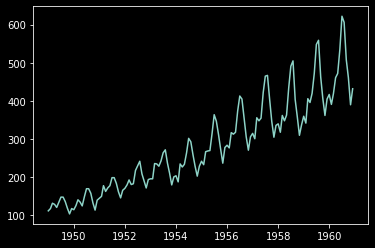

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df['Passengers']=df['#Passengers']
df.set_index('Month', inplace=True) 
df = df.drop(columns = ['#Passengers'])
print(df.dtypes)
print(df.head())
plt.plot(df['Passengers'])

In [12]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #Convert values to float

In [13]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [14]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [15]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

seq_size = 20 # Number of time steps to look back

#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#Also generate validation data
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)


Total number of samples in the original training data =  95
Total number of samples in the generated data =  75


In [16]:
print('Build feed forward NN model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary())

Build feed forward NN model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
75/75 - 1s - loss: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0345
Epoch 2/100
75/75 - 0s - loss: 0.0043 - acc: 0.0000e+00 - val_loss: 0.0144 - val_acc: 0.0345
Epoch 3/100
75/75 - 0s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0097 - val_acc: 0.0345
Epoch 4/100
75/75 - 0s - loss: 0.0025 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0345
Epoch 5/100
75/75 - 0s - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0345
Epoch 6/100
75/75 - 0s - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0345
Epoch 7/100
75/75 - 0s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0345
Epoch 8/100
75/75 - 0s - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 0.0345
Epoch 9/100
75/75 - 0s - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0345
Epoch 10/100
75/75 - 0s - loss: 8.7326e-04 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0345
Epoch 11/100
75/75 - 0s - loss: 8.5848e-04 - acc: 0.0000e+00 - va

In [18]:
# make predictions
trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

In [19]:
# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

Train Score: 8.28 RMSE
Test Score: 26.07 RMSE


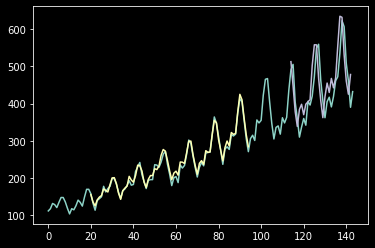

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()